### Import packages

In [1]:
import pathlib
import os
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import h5py
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import hausdorff_distance as HD
from skimage.metrics import normalized_mutual_information as NMI
from skimage.restoration import denoise_tv_chambolle
from skimage import filters
import pandas as pd

### Mount drive

dataset at DLMI/datasets/CE_downsample \\
outputs at DLMI/models

In [2]:
import google
google.colab.drive.mount('/content/drive', force_remount=True)
drive = pathlib.Path('./drive/MyDrive') / 'DLMI'

Mounted at /content/drive


### Dataset

In [3]:
class DatasetCBCT(torch.utils.data.Dataset):
  def __init__(self,directory,noiseFunc=None,is_test=False):
    super().__init__()
    self.files=[os.path.join(directory,f) for f in os.listdir(directory) if f.endswith('.h5')] # all file paths
    self.num_slices=32 # number of slices in an image
    self.noiseFunc=noiseFunc # noise function
    self.is_test=is_test # is training or testing
    self.images_fix=[] # motion-free images
    self.images_motion=[] # motion-affected images

    # load files
    for file in self.files:
      with h5py.File(file,'r') as f:
        image_fix=f['fixIm']
        image_motion=f['moIm']
        for i in range(self.num_slices):
          self.images_fix.append(image_fix[i,:,:])
          self.images_motion.append(image_motion[i,:,:])

  def __len__(self):
    return len(self.files) # number of files

  def preprocess(self,x):
    return (x-x.min())/(x.max()-x.min())*2-1 # min-max normalization

  def __getitem__(self,index):
    if self.is_test: # return all slices in an image when testing
      image_fix=np.array(self.images_fix[index*self.num_slices:(index+1)*self.num_slices])
      image_motion=np.array(self.images_motion[index*self.num_slices:(index+1)*self.num_slices])
      image_fix=torch.from_numpy(image_fix).float()
      image_motion=torch.from_numpy(image_motion).float()
      for i in range(image_fix.size(0)):
        image_fix[i,:,:]=self.preprocess(image_fix[i,:,:])
        image_motion[i,:,:]=self.preprocess(image_motion[i,:,:])
    else: # randomly choose one slice in an image when training
      index_slice=np.random.randint(0,self.num_slices)
      image_fix=self.images_fix[index*self.num_slices+index_slice]
      image_motion=self.images_motion[index*self.num_slices+index_slice]
      image_fix=torch.from_numpy(image_fix).float().unsqueeze(0)
      image_motion=torch.from_numpy(image_motion).float().unsqueeze(0)
      if self.noiseFunc is not None:
        image_fix=self.noiseFunc(image_fix)
        image_motion=self.noiseFunc(image_motion)
      image_fix=self.preprocess(image_fix)
      image_motion=self.preprocess(image_motion)

    return image_motion,image_fix

load dataset and dataloaders

In [4]:
dataset=DatasetCBCT(os.path.join(drive,'datasets','CE_downsample'))

generator=torch.Generator().manual_seed(42)
train_dataset,val_dataset,test_dataset=random_split(dataset,[0.6,0.2,0.2],generator=generator)

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=False)

visualize some samples

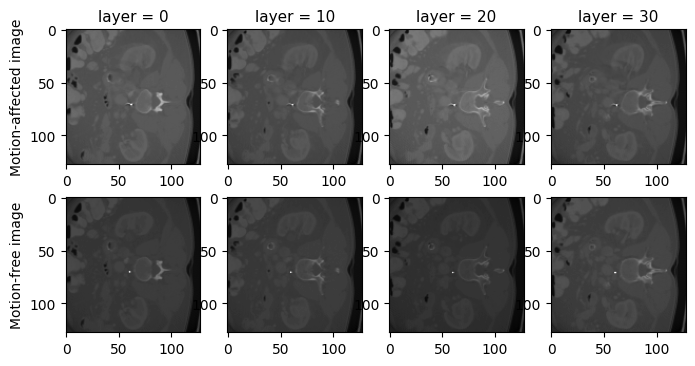

In [17]:
dataset.is_test=True
n_images=4 # display 4 slices in an image
fig,axs=plt.subplots(ncols=n_images,nrows=2,figsize=(n_images*2,4))
i=0
for images_motion,images_fix in test_loader:
  for i in range(4):
    axs[0,i].imshow(np.squeeze(images_motion[0,10*i].numpy()),cmap='gray')
    axs[1,i].imshow(np.squeeze(images_fix[0,10*i].numpy()),cmap='gray')
    axs[0,i].set_title(f'layer = {10*i}',size=11)
  break
axs[0,0].set_ylabel('Motion-affected image')
axs[1,0].set_ylabel('Motion-free image')
dataset.is_test=False

### Generator

In [16]:
class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.double_conv=nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3,1,1),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(negative_slope=0.1,inplace=True),
      nn.Conv2d(out_channels,out_channels,3,1,1),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(negative_slope=0.1,inplace=True)
    )
  def forward(self,x):
    return self.double_conv(x)

class Generator(nn.Module):
  def __init__(self,in_channels=1,out_channels=1,p=0.25):
    super(Generator,self).__init__()
    self.enc1=ConvBlock(in_channels,32)
    self.enc2=ConvBlock(32,64)
    self.enc3=ConvBlock(64,128)
    self.enc4=ConvBlock(128,256)
    self.enc5=ConvBlock(256,512)

    self.maxpool=nn.MaxPool2d(2)
    self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)

    self.dec1=ConvBlock(512+256,256)
    self.dec2=ConvBlock(256+128,128)
    self.dec3=ConvBlock(128+64,64)
    self.dec4=ConvBlock(64+32,32)

    self.oput=nn.Conv2d(32,out_channels,1)
    self.drop=nn.Dropout(p)
    self.act=nn.Tanh()

    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data,mode='fan_in',nonlinearity='leaky_relu')
        m.bias.data.zero_()

  def forward(self,x):
    x1=self.enc1(x)
    x=self.maxpool(x1)
    x=self.drop(x)

    x2=self.enc2(x)
    x=self.maxpool(x2)
    x=self.drop(x)

    x3=self.enc3(x)
    x=self.maxpool(x3)
    x=self.drop(x)

    x4=self.enc4(x)
    x=self.maxpool(x4)
    x=self.drop(x)

    x=self.enc5(x)

    x=self.upsample(x)
    x=self.drop(x)
    x=torch.cat([x,x4],dim=1)
    x=self.dec1(x)

    x=self.upsample(x)
    x=self.drop(x)
    x=torch.cat([x,x3],dim=1)
    x=self.dec2(x)

    x=self.upsample(x)
    x=self.drop(x)
    x=torch.cat([x,x2],dim=1)
    x=self.dec3(x)

    x=self.upsample(x)
    x=self.drop(x)
    x=torch.cat([x,x1],dim=1)
    x=self.dec4(x)

    x=self.oput(x)
    x=self.act(x)

    return x

### Discriminator

In [7]:
class DiscriminatorBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.conv=nn.Conv2d(in_channels,out_channels,3,2,1)
    self.bn=nn.BatchNorm2d(out_channels)
    self.act=nn.LeakyReLU(negative_slope=0.1,inplace=True)

  def forward(self,x):
    return self.act(self.bn(self.conv(x)))


class Discriminator(nn.Module):
  def __init__(self,in_channels=2):
    super(Discriminator,self).__init__()
    self.conv1=DiscriminatorBlock(in_channels,16)
    self.conv2=DiscriminatorBlock(16,32)
    self.conv3=DiscriminatorBlock(32,64)
    self.conv4=DiscriminatorBlock(64,128)
    self.conv5=DiscriminatorBlock(128,128)
    self.oput=nn.Conv2d(128,1,4)
    self.act=nn.Sigmoid()

    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data,mode='fan_in',nonlinearity='leaky_relu')
        m.bias.data.zero_()

  def forward(self,x1,x2):
    x=torch.cat([x1,x2],dim=1)
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)
    x=self.oput(x)
    x=self.act(x)

    return x

### Feature extractor (for perceptual loss)

In [8]:
# use first 3 conv maps of the discriminator as features
class FeatureExtractor(nn.Module):
    def __init__(self, discriminator):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            discriminator.conv1,
            discriminator.conv2,
            discriminator.conv3
        )

    def forward(self, x):
        outputs = []
        for layer in self.features:
            xout=layer.conv(x)
            outputs.append(xout)
            x = layer(x)
        return outputs

class PerceptualLoss(nn.Module):
    def __init__(self, feature_extractor):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, generated, real, motion):
        real_features = self.feature_extractor(torch.cat((real,motion),dim=1))
        generated_features = self.feature_extractor(torch.cat((generated,motion),dim=1))
        loss = 0
        for real_feat, gen_feat in zip(real_features, generated_features):
            loss += torch.mean((real_feat - gen_feat) ** 2)  # L2 Loss for each feature map
        return loss

### Start training!

model

In [9]:
generator=Generator()
discriminator=Discriminator()

device=torch.device('cuda')
generator=generator.to(device)
discriminator=discriminator.to(device)

setup

In [10]:
# learning rates
num_epochs=1000
lr_gen=1e-3
lr_dis=8e-5

# define optimizers
optimizer_gen=torch.optim.Adam(generator.parameters(),lr=lr_gen)
optimizer_dis=torch.optim.Adam(discriminator.parameters(),lr=lr_dis)
scheduler_gen=torch.optim.lr_scheduler.StepLR(optimizer_dis,step_size=100,gamma=0.8)
scheduler_dis=torch.optim.lr_scheduler.StepLR(optimizer_dis,step_size=100,gamma=0.8)

# define losses
pix_loss=nn.MSELoss()
dis_loss=nn.BCELoss()
per_loss=PerceptualLoss(FeatureExtractor(discriminator))
lambda_pix=20.
lambda_GAN=1.
lambda_per=10.

path_weights=os.path.join(drive,'models','cGAN.pt')

training loop

In [11]:
losses_gen_train=[]
losses_dis_train=[]
losses_gen_val=[]
losses_dis_val=[]
losses_pix_val=[]
losses_GAN_val=[]
losses_per_val=[]

for epoch in tqdm(range(num_epochs)):

  # train
  generator.train()
  discriminator.train()
  loss_gen_train=0
  loss_dis_train=0

  for images_motion,images_fix in train_loader:

    images_motion,images_fix=images_motion.to(device),images_fix.to(device)

    valid=torch.as_tensor(np.ones((images_motion.size(0),1,1,1)),dtype=torch.float32)
    fake=torch.as_tensor(np.zeros((images_motion.size(0),1,1,1)),dtype=torch.float32)
    valid,fake=valid.to(device),fake.to(device)

    # train generator
    optimizer_gen.zero_grad()
    images_fake=generator(images_motion)
    pred_fake=discriminator(images_fake,images_motion)
    loss_GAN=dis_loss(pred_fake,valid)
    loss_pix=pix_loss(images_fake,images_fix)
    loss_per=per_loss(images_fake,images_fix,images_motion)
    loss_gen=lambda_GAN*loss_GAN+lambda_pix*loss_pix+lambda_per*loss_per
    loss_gen.backward()
    optimizer_gen.step()
    loss_gen_train+=loss_gen.item()

    # train discriminator
    optimizer_dis.zero_grad()
    pred_real=discriminator(images_fix,images_motion)
    loss_real=dis_loss(pred_real,valid)
    images_fake=generator(images_motion)
    pred_fake=discriminator(images_fake.detach(),images_motion)
    loss_fake=dis_loss(pred_fake,fake)
    loss_dis=loss_real+loss_fake
    loss_dis.backward()
    optimizer_dis.step()
    loss_dis_train+=loss_dis.item()

  losses_gen_train.append(loss_gen_train/len(train_loader))
  losses_dis_train.append(loss_dis_train/len(train_loader))

  # progress check
  if epoch%10==0:
    print(f'Epoch {epoch}: loss_gen = {losses_gen_train[-1]}, loss_dis = {losses_dis_train[-1]}')

  # validation
  generator.eval()
  discriminator.eval()
  loss_gen_val=0
  loss_dis_val=0
  loss_pix_val=0
  loss_GAN_val=0
  loss_per_val=0

  for images_motion,images_fix in val_loader:

    images_motion,images_fix=images_motion.to(device),images_fix.to(device)

    valid=torch.as_tensor(np.ones((images_motion.size(0),1,1,1)),dtype=torch.float32)
    fake=torch.as_tensor(np.zeros((images_motion.size(0),1,1,1)),dtype=torch.float32)
    valid,fake=valid.to(device),fake.to(device)

    images_fake=generator(images_motion)
    pred_fake=discriminator(images_fake,images_motion)
    loss_GAN=dis_loss(pred_fake,valid)
    loss_pix=pix_loss(images_fake,images_fix)
    loss_per=per_loss(images_fake,images_fix,images_motion)
    loss_gen=lambda_GAN*loss_GAN+lambda_pix*loss_pix+lambda_per*loss_per

    loss_pix_val+=loss_pix.item()
    loss_GAN_val+=loss_GAN.item()
    loss_per_val+=loss_per.item()
    loss_gen_val+=loss_gen.item()

    # train discriminator
    pred_real=discriminator(images_fix,images_motion)
    loss_real=dis_loss(pred_real,valid)
    images_fake=generator(images_motion)
    pred_fake=discriminator(images_fake.detach(),images_motion)
    loss_fake=dis_loss(pred_fake,fake)
    loss_dis=loss_real+loss_fake
    loss_dis_val+=loss_dis.item()

  losses_pix_val.append(loss_pix_val/len(val_loader))
  losses_GAN_val.append(loss_GAN_val/len(val_loader))
  losses_per_val.append(loss_per_val/len(val_loader))
  losses_gen_val.append(loss_gen_val/len(val_loader))
  losses_dis_val.append(loss_dis_val/len(val_loader))

torch.save(generator.state_dict(),path_weights)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: loss_gen = 15.547222069331578, loss_dis = 1.3203427365847997
Epoch 10: loss_gen = 6.834480047225952, loss_dis = 0.944744484765189
Epoch 20: loss_gen = 7.3025432995387485, loss_dis = 1.0475674058709825
Epoch 30: loss_gen = 6.751520156860352, loss_dis = 0.8810314663818904
Epoch 40: loss_gen = 6.504502313477652, loss_dis = 0.8382390822683062
Epoch 50: loss_gen = 5.027814405305045, loss_dis = 0.8917264470032283
Epoch 60: loss_gen = 4.4102567945207864, loss_dis = 0.9304825152669635
Epoch 70: loss_gen = 5.6595054013388495, loss_dis = 0.7635510989597866
Epoch 80: loss_gen = 5.445887242044721, loss_dis = 0.8742443514721734
Epoch 90: loss_gen = 5.4038267476218085, loss_dis = 0.6881618031433651
Epoch 100: loss_gen = 4.75431443963732, loss_dis = 0.804363876581192
Epoch 110: loss_gen = 4.525934951645987, loss_dis = 0.7244921582085746
Epoch 120: loss_gen = 5.089832067489624, loss_dis = 0.7635270037821361
Epoch 130: loss_gen = 4.448946458952768, loss_dis = 0.9105492872851235
Epoch 140: loss

### Plot loss curve

training loss

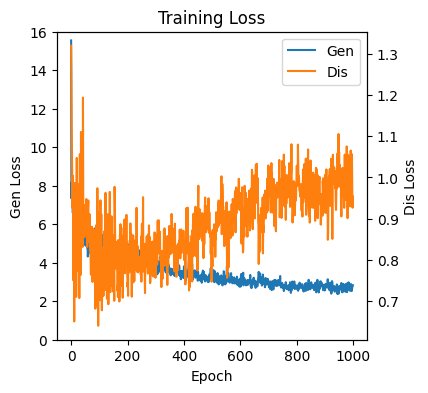

In [14]:
fig,ax=plt.subplots(figsize=(4,4))
lines1=ax.plot(losses_gen_train,'C0')
ax.set_ylabel('Gen Loss')
ax.set_ylim(0,16)
axr=ax.twinx()
lines2=axr.plot(losses_dis_train,'C1')
axr.set_ylabel('Dis Loss')
ax.set_xlabel('Epoch')
ax.legend([lines1[0],lines2[0]],['Gen','Dis'])
plt.title('Training Loss')
plt.show()

validation loss

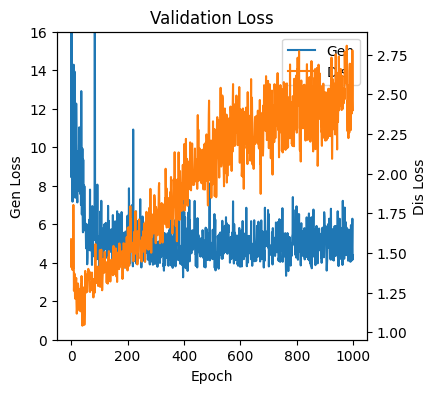

In [15]:
fig,ax=plt.subplots(figsize=(4,4))
lines1=ax.plot(losses_gen_val,'C0')
ax.set_ylabel('Gen Loss')
ax.set_ylim(0,16)
axr=ax.twinx()
lines2=axr.plot(losses_dis_val,'C1')
axr.set_ylabel('Dis Loss')
ax.set_xlabel('Epoch')
ax.legend([lines1[0],lines2[0]],['Gen','Dis'])
plt.title('Validation Loss')
plt.show()

individual loss parts

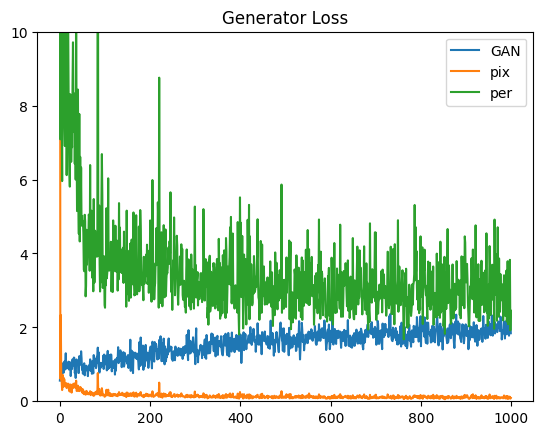

In [21]:
plt.plot(lambda_GAN*np.array(losses_GAN_val),label='GAN')
plt.plot(lambda_pix*np.array(losses_pix_val),label='pix')
plt.plot(lambda_per*np.array(losses_per_val),label='per')
plt.ylim(0,10)
plt.legend()
plt.title('Generator Loss')
plt.show()

### Sample Visualization

high-quality

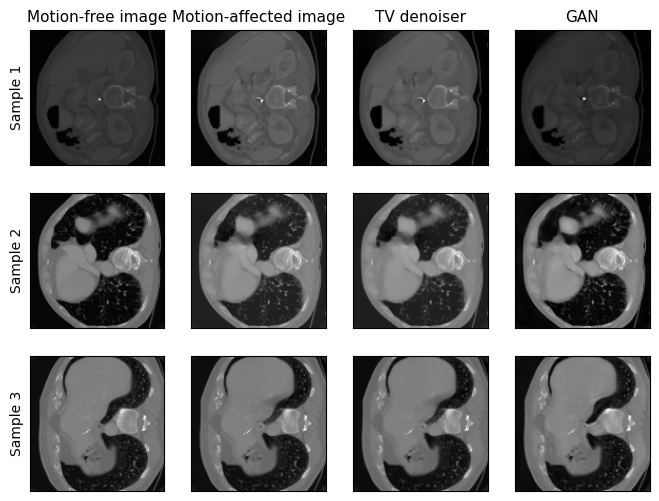

In [90]:
dataset.is_test=True
model = Generator()
model.load_state_dict(torch.load(os.path.join(drive,'models','cGAN.pt')))
device=torch.device('cuda')
model.to(device)
model.eval()
fig,axs=plt.subplots(ncols=4,nrows=3,figsize=(8,6))
subjects=[25,72,106]
layers=[15,15,15]

for i in range(3):
  images_motion,images_fix=test_dataset[subjects[i]]
  image_motion=images_motion[layers[i]].unsqueeze(0).unsqueeze(0)
  image_fix=images_fix[layers[i]].unsqueeze(0).unsqueeze(0)
  image_motion=image_motion.to(device)
  image_fake=model(image_motion)
  image_tv=denoise_tv_chambolle(image_motion.cpu().detach().numpy(),weight=0.01)
  axs[i,0].imshow(np.squeeze(image_fix.numpy()),cmap='gray')
  axs[i,1].imshow(np.squeeze(image_motion.cpu().detach().numpy()),cmap='gray')
  axs[i,2].imshow(np.squeeze(image_tv),cmap='gray')
  axs[i,3].imshow(np.squeeze(image_fake.cpu().detach().numpy()),cmap='gray')
  for j in range(4):
    axs[i,j].set_xticks([]), axs[i,j].set_yticks([])

axs[0,0].set_title('Motion-free image',size=11)
axs[0,1].set_title('Motion-affected image',size=11)
axs[0,2].set_title('TV denoiser',size=11)
axs[0,3].set_title('GAN',size=11)
axs[0,0].set_ylabel('Sample 1')
axs[1,0].set_ylabel('Sample 2')
axs[2,0].set_ylabel('Sample 3')
plt.show()
dataset.is_test=False

medium quality

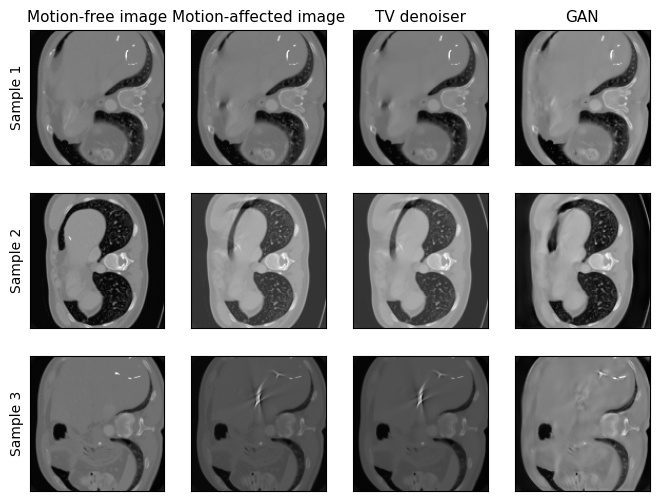

In [80]:
dataset.is_test=True
model = Generator()
model.load_state_dict(torch.load(os.path.join(drive,'models','cGAN.pt')))
device=torch.device('cuda')
model.to(device)
model.eval()
fig,axs=plt.subplots(ncols=4,nrows=3,figsize=(8,6))
subjects=[46,50,135]
layers=[15,15,15]

for i in range(3):
  images_motion,images_fix=test_dataset[subjects[i]]
  image_motion=images_motion[layers[i]].unsqueeze(0).unsqueeze(0)
  image_fix=images_fix[layers[i]].unsqueeze(0).unsqueeze(0)
  image_motion=image_motion.to(device)
  image_fake=model(image_motion)
  image_tv=denoise_tv_chambolle(image_motion.cpu().detach().numpy(),weight=0.01)
  axs[i,0].imshow(np.squeeze(image_fix.numpy()),cmap='gray')
  axs[i,1].imshow(np.squeeze(image_motion.cpu().detach().numpy()),cmap='gray')
  axs[i,2].imshow(np.squeeze(image_tv),cmap='gray')
  axs[i,3].imshow(np.squeeze(image_fake.cpu().detach().numpy()),cmap='gray')
  for j in range(4):
    axs[i,j].set_xticks([]), axs[i,j].set_yticks([])

axs[0,0].set_title('Motion-free image',size=11)
axs[0,1].set_title('Motion-affected image',size=11)
axs[0,2].set_title('TV denoiser',size=11)
axs[0,3].set_title('GAN',size=11)
axs[0,0].set_ylabel('Sample 1')
axs[1,0].set_ylabel('Sample 2')
axs[2,0].set_ylabel('Sample 3')
plt.show()
dataset.is_test=False

### Calculate scores

In [56]:
dataset.is_test=True
model = Generator()
model.load_state_dict(torch.load(os.path.join(drive,'models','cGAN.pt')))
device=torch.device('cuda')
model.to(device)
model.eval()

# GAN-generated image scores
fake_scores={
  'mse':[],
  'psnr':[],
  'ssim':[],
  'hd':[]
}
# motion-affected image scores
motion_scores={
  'mse':[],
  'psnr':[],
  'ssim':[],
  'hd':[]
}
# total variance denoising image scores
tv_scores={
  'mse':[],
  'psnr':[],
  'ssim':[],
  'hd':[]
}
mse_func=nn.MSELoss()

for images_motion,images_fix in test_loader:
  images_motion=images_motion.permute(1,0,2,3)
  images_fix=images_fix.permute(1,0,2,3)
  images_motion,images_fix=images_motion.to(device),images_fix.to(device)
  images_fake=model(images_motion)
  images_motion=images_motion.cpu().detach()
  images_fake=images_fake.cpu().detach()
  images_fix=images_fix.cpu().detach()
  for i in range(dataset.num_slices):
    image_motion=images_motion[i,0]
    image_fake=images_fake[i,0]
    image_fix=images_fix[i,0]
    image_tv=denoise_tv_chambolle(image_motion.numpy(),weight=0.01)
    thresh = filters.threshold_otsu(image_fix.numpy())

    # GAN
    fake_scores['mse'].append(mse_func(image_fake,image_fix).item())
    fake_scores['psnr'].append(PSNR(image_fix.numpy(),image_fake.numpy(),data_range=2))
    fake_scores['ssim'].append(SSIM(image_fix.numpy(),image_fake.numpy(),data_range=2))
    fake_scores['hd'].append(HD(image_fix.numpy()>thresh,image_fake.numpy()>thresh))

    # motion-affected
    motion_scores['mse'].append(mse_func(image_motion,image_fix).item())
    motion_scores['psnr'].append(PSNR(image_fix.numpy(),image_motion.numpy(),data_range=2))
    motion_scores['ssim'].append(SSIM(image_fix.numpy(),image_motion.numpy(),data_range=2))
    motion_scores['hd'].append(HD(image_fix.numpy()>thresh,image_motion.numpy()>thresh))

    # TV
    tv_scores['mse'].append(mse_func(torch.from_numpy(image_tv),image_fix).item())
    tv_scores['psnr'].append(PSNR(image_fix.numpy(),image_tv,data_range=2))
    tv_scores['ssim'].append(SSIM(image_fix.numpy(),image_tv,data_range=2))
    tv_scores['hd'].append(HD(image_fix.numpy()>thresh,image_tv>thresh))

# save to excel
df = pd.DataFrame(fake_scores)
df.to_excel(os.path.join(drive,'models','fake_scores.xlsx'), index=False, engine='openpyxl')
df = pd.DataFrame(motion_scores)
df.to_excel(os.path.join(drive,'models','motion_scores.xlsx'), index=False, engine='openpyxl')
df = pd.DataFrame(tv_scores)
df.to_excel(os.path.join(drive,'models','tv_scores.xlsx'), index=False, engine='openpyxl')
dataset.is_test=False

### Statistics

read scores from excel

In [10]:
df=pd.read_excel(os.path.join(drive,'models','fake_scores.xlsx'))
fake_scores = df.to_dict(orient='list')
df=pd.read_excel(os.path.join(drive,'models','motion_scores.xlsx'))
motion_scores = df.to_dict(orient='list')
df=pd.read_excel(os.path.join(drive,'models','tv_scores.xlsx'))
tv_scores = df.to_dict(orient='list')

calculate mean and std

In [17]:
print(np.mean(fake_scores['mse']),np.mean(motion_scores['mse']),np.mean(tv_scores['mse']))
print(np.mean(fake_scores['psnr']),np.mean(motion_scores['psnr']),np.mean(tv_scores['psnr']))
print(np.mean(fake_scores['ssim']),np.mean(motion_scores['ssim']),np.mean(tv_scores['ssim']))
print(np.mean(fake_scores['hd']),np.mean(motion_scores['hd']),np.mean(tv_scores['hd']))

print(np.std(fake_scores['mse']),np.std(motion_scores['mse']),np.std(tv_scores['mse']))
print(np.std(fake_scores['psnr']),np.std(motion_scores['psnr']),np.std(tv_scores['psnr']))
print(np.std(fake_scores['ssim']),np.std(motion_scores['ssim']),np.std(tv_scores['ssim']))
print(np.std(fake_scores['hd']),np.std(motion_scores['hd']),np.std(tv_scores['hd']))

0.004862806957153471 0.01996392863075792 0.01992667268235833
33.26463703588936 31.497022491010775 31.214004771640763
0.9010581506202872 0.8519759822784134 0.8497714106187493
5.850868987542984 5.873981707509195 6.061853286570157
0.01351470781550053 0.04400584520076927 0.04391432555548956
5.516634482749732 9.705812671680604 9.230359333703518
0.11893927502481762 0.19633820488818587 0.19452610426045144
5.3867542121354575 5.761164635201933 5.785357559992593


box plot

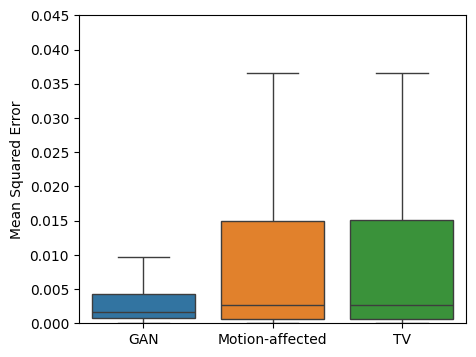

In [56]:
import seaborn as sns
data = pd.DataFrame({
    'GAN': np.array(fake_scores['mse']),
    'Motion-affected': np.array(motion_scores['mse']),
    'TV': np.array(tv_scores['mse'])
})
plt.figure(figsize=(5,4))
ax=sns.boxplot(data=data,flierprops=dict(marker='None'))
ax.set_ylim(0,0.045)
plt.ylabel('Mean Squared Error')
plt.show()

Mann-Whitney U test

In [57]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(fake_scores['mse'],motion_scores['mse'])
print(stat,p_value)
stat, p_value = mannwhitneyu(fake_scores['mse'],tv_scores['mse'])
print(stat,p_value)
stat, p_value = mannwhitneyu(tv_scores['mse'],motion_scores['mse'])
print(stat,p_value)

9785058.5 6.255031096163638e-27
9731831.0 7.572091478763559e-29
11303700.0 0.5043069029419633
